<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
</div>

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

In [31]:
!nvidia-smi

Mon Aug 15 18:41:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |    798MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
import tensorflow as tf
print(tf.version.VERSION)

2.8.2


In [33]:
!pip install -q tensorflow==2.3.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray-einstats 0.2.2 requires numpy>=1.21, but you have numpy 1.18.5 which is incompatible.
tables 3.7.0 requires numpy>=1.19.0, but you have numpy 1.18.5 which is incompatible.
pymc3 3.11.5 requires scipy<1.8.0,>=1.7.3, but you have scipy 1.4.1 which is incompatible.
pandas-gbq 0.13.3 requires google-cloud-bigquery[bqstorage,pandas]<2.0.0dev,>=1.11.1, but you have google-cloud-bigquery 3.3.1 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jaxlib 0.3.14+cuda11.cudnn805 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
jax 0.3.14 requires numpy>=1.19, but you have numpy 1.18.5 which is incompatible.
jax 0.3.14 requires scipy>=1.5, but you have scipy 1.4.1 which is incompatible.
cmdstanpy 1.0.4 requires numpy>=1.21, but y

In [34]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [35]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you have scipy 1.7.3 which is incompatible.
pandas-gbq 0.13.3 requires google-cloud-bigquery[bqstorage,pandas]<2.0.0dev,>=1.11.1, but you have google-cloud-bigquery 3.3.1 which is incompatible.


## Import the Quora Insincere Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.3.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [61]:
import numpy as np
import pandas as pd

df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip",
                 compression="zip", low_memory=False)
df.shape

(1306122, 3)

In [62]:
df.tail(10)

,qid,question_text,target
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1
1306113,ffffae5dbda3dc9e9771,What are the methods to determine fossil ages ...,0
1306114,ffffba7c4888798571c1,What is your story today?,0
1306115,ffffc0c7158658a06fd9,How do I consume 150 gms protein daily both ve...,0
1306116,ffffc404da586ac5a08f,What are the good career options for a msc che...,0
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


<AxesSubplot:title={'center':'Target Distribution'}, ylabel='Frequency'>

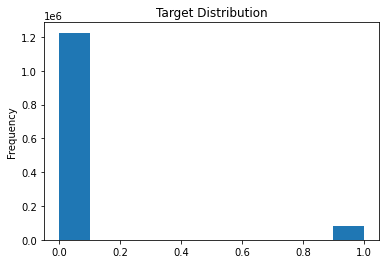

In [63]:
df.target.plot(kind="hist", title="Target Distribution")

## Create tf.data.Datasets for Training and Evaluation

In [64]:
from sklearn.model_selection import train_test_split

train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df["target"])
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.0075, stratify=remaining["target"])

train_df.shape, valid_df.shape

((9795, 3), (9722, 3))

In [65]:
with tf.device("/cpu:0"):
  train_data = tf.data.Dataset.from_tensor_slices((train_df["question_text"].values, train_df["target"].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df["question_text"].values, valid_df["target"].values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Pre-trained BERT Model from TensorFlow Hub

In [66]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

label_list = [0, 1]
max_seq_length = 128
train_batch_size = 32

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)



In [67]:
tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?")

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [68]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize("hi, how are you doing?"))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [69]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())
                                            
  feature = classifier_data_lib.convert_single_example(0, 
                                                       example, 
                                                       label_list,
                                                       max_seq_length, 
                                                       tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Wrap a Python Function into a TensorFlow op for Eager Execution

In [70]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, 
                                                                inp=[text, label], 
                                                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

## Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
from tensorflow._api.v2.data import experimental
from tensorflow.python.data.experimental.ops.prefetching_ops import prefetch_to_device
from tensorflow.python.ops.gen_batch_ops import batch
with tf.device('/cpu:0'):

  train_data = (train_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .shuffle(1000)
                .batch(train_batch_size, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (valid_data.map(to_feature_map, 
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
                .batch(32, drop_remainder=True)
                .prefetch(tf.data.experimental.AUTOTUNE))

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [72]:
# data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [73]:
# data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />

</div>

In [74]:
def create_model():  
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length), 
                                         dtype=tf.int32,
                                         name="input_word_ids")
  
  input_mask = tf.keras.layers.Input(shape=(max_seq_length), 
                                     dtype=tf.int32,
                                     name="input_mask")
  
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length), 
                                         dtype=tf.int32,
                                         name="input_type_ids")


  pooled_output, sequence_output = bert_layer([input_word_ids, 
                                               input_mask, 
                                               input_type_ids])


  dropout = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(dropout)

  model = tf.keras.Model(
      inputs={
          "input_word_ids":input_word_ids,
          "input_mask":input_mask,
          "input_type_ids": input_type_ids
      },
      outputs=output
  )
  return model

## Fine-Tune BERT for Text Classification

In [75]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

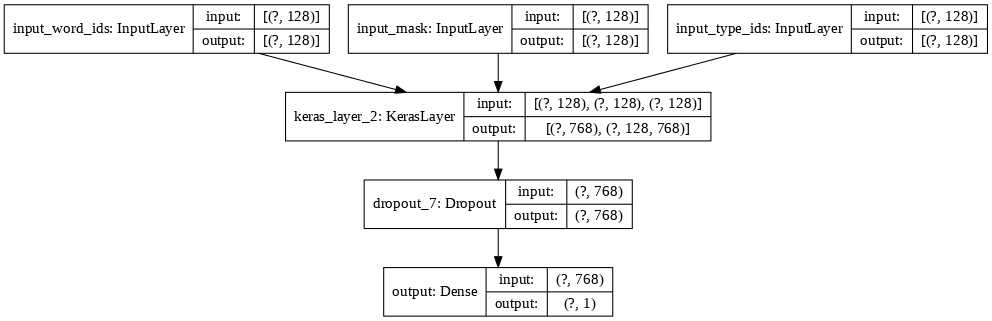

In [76]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [78]:
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
306/306 [==============================] - ETA: 0s - loss: 0.1712 - binary_accuracy: 0.9371

306/306 [==============================] - 348s 1s/step - loss: 0.1712 - binary_accuracy: 0.9371 - val_loss: 0.1193 - val_binary_accuracy: 0.9534
Epoch 2/4
306/306 [==============================] - 349s 1s/step - loss: 0.0945 - binary_accuracy: 0.9644 - val_loss: 0.1499 - val_binary_accuracy: 0.9503
Epoch 3/4
306/306 [==============================] - 351s 1s/step - loss: 0.0553 - binary_accuracy: 0.9817 - val_loss: 0.1623 - val_binary_accuracy: 0.9540
Epoch 4/4
306/306 [==============================] - 350s 1s/step - loss: 0.0255 - binary_accuracy: 0.9920 - val_loss: 0.2199 - val_binary_accuracy: 0.9485


## Evaluate the BERT Text Classification Model

In [80]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

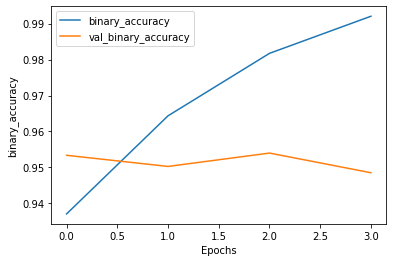

In [81]:
plot_graphs(history, 'binary_accuracy')

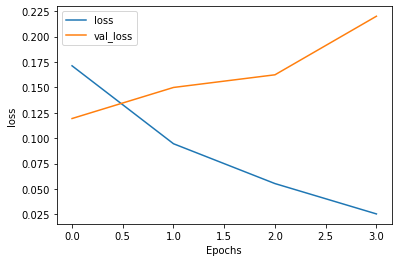

In [82]:
plot_graphs(history, 'loss')

In [83]:
model.evaluate(valid_data, verbose=1)

  2/303 [..............................] - ETA: 1:24 - loss: 0.3201 - binary_accuracy: 0.9531

303/303 [==============================] - 93s 307ms/step - loss: 0.2199 - binary_accuracy: 0.9485


[0.21993200480937958, 0.9485355019569397]

In [84]:
sample_example = [" that's soo sweet "]
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)
preds = ['Insincere' if pred >=0.5 else 'Sincere' for pred in preds]

In [85]:
preds

['Sincere']